## Dataset

Veamos estadísticas y otras cosas del dataset

In [1]:
%load_ext autoreload
%autoreload 2
import os
import sys
import django
from tqdm.auto import tqdm

os.environ["DJANGO_ALLOW_ASYNC_UNSAFE"] = "true"

sys.path.append("..")
os.environ['DJANGO_SETTINGS_MODULE'] = 'news_labelling.settings'
django.setup()

from api.models import Comment, ArticleLabel, CommentLabel, Article, Batch
from django.contrib.auth.models import User

Primero, veamos qué usuarios etiquetaron más de 4 artículos...

In [2]:
from django.db.models import Count, Case, When, Value

annotated_articles = Article.objects.exclude(batch__name="training").annotate(
    num_labels=Count('labels'),
    effective_labels=Count(
        Case(When(labels__is_interesting=True, then=Value(1)))
    )
)


dataset_articles = annotated_articles.filter(effective_labels=3)

skipped = 0

for art in annotated_articles:
    if art.num_labels > art.effective_labels:
        skipped +=1


print(f"Artículos totales: {Article.objects.count()}")
print(f"Artículos con 3 anotaciones: {dataset_articles.count()}")
print(f"Artículos con alguna anotación: {annotated_articles.filter(num_labels__gte=1).count()}")
print(f"Artículos que no pasaron a tercera anotación: {skipped}")

Artículos totales: 1738
Artículos con 3 anotaciones: 1238
Artículos con alguna anotación: 1725
Artículos que no pasaron a tercera anotación: 452


Vamos a crear primero tabla de comentarios

Text(0.5, 1.0, 'Distribution of article dates')

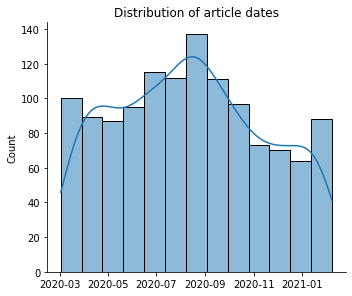

In [3]:
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt

dates = [d.created_at for d in dataset_articles]

ax = sns.displot(
    x=dates, 
    kde=True, 
    height=4, aspect=1.25,
)

plt.title("Distribution of article dates")

In [48]:
Article.objects.annotate(total_comments=Count('comment'))[0].total_comments

50

In [60]:
q[0]

{'user': 'LANACION', 'total': 222}

In [101]:
from django.db.models import Sum
import pandas as pd

"""
Me cansé, vamos con Pandas
"""
q = Article.objects.filter(id__in=[d.id for d in dataset_articles])




df_count = pd.DataFrame([{
    "user": art.user,
    "num comments": art.comment_set.count(),
} for art in q])
#df_count.plot(y="total", kind="pie", figsize=(5, 5), legend=False)
#plt.ylabel("")

df_sum = df_count.groupby("user").sum('num comments')
df_num_articles = df_count.groupby("user").count()

df = pd.concat([df_num_articles, df_sum], axis=1)
df.columns = ["#Articles", "#Comments"]
df = df.sort_values("#Articles", ascending=False)
df

,#Articles,#Comments
user,,
infobae,590,26834
clarincom,370,17501
LANACION,222,10378
cronica,42,1562
perfilcom,14,594


In [102]:
print(df.to_latex())

\begin{tabular}{lrr}
\toprule
{} &  \#Articles &  \#Comments \\
user      &            &            \\
\midrule
infobae   &        590 &      26834 \\
clarincom &        370 &      17501 \\
LANACION  &        222 &      10378 \\
cronica   &         42 &       1562 \\
perfilcom &         14 &        594 \\
\bottomrule
\end{tabular}



In [4]:


comments = pd.DataFrame([{
    "comment_id": comment.tweet_id,
    "article_id": art.tweet_id,
    "text": comment.text,
    "user_id": comment.user_id,
} for art in dataset_articles for comment in art.comment_set.all()])

comments.set_index("comment_id", inplace=True)

comments

,article_id,text,user_id
comment_id,,,
1241513939499876354,1241486782178435072,@usuario Momento oportuno para hacer esa movid...,1173653523478851593
1241524087773593600,1241486782178435072,@usuario vienen medicos cubanos... ahhh pero n...,2492207160
1241493802222850049,1241486782178435072,@usuario Otros virus más?,900774786736979969
1241776452300869632,1241486782178435072,@usuario Quien diría q un día Cristina estaría...,1218288879800811521
1241801967669776384,1241486782178435072,"@usuario Ya que no devuelven TODO,es lo menos ...",3144238919
...,...,...,...
1357362025203200002,1357326733058461696,@usuario Nunca olvidar que este gobierno hizo ...,147954815
1357358187712757762,1357326733058461696,@usuario Esos pseudohumanos nos están matando ...,150045518
1357528904228081664,1357326733058461696,"@usuario Que tristeza dios mio, que en paz des...",615411644


[]

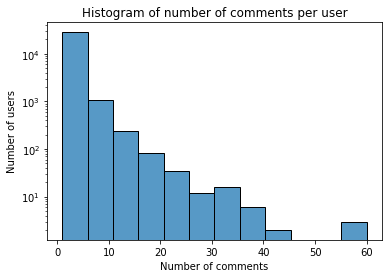

In [5]:
user_counts = comments["user_id"].value_counts().to_frame("number of comments")
sns.histplot(data=user_counts, x="number of comments", hue=None, bins=12)

plt.ylabel("Number of users")
plt.xlabel("Number of comments")
plt.title("Histogram of number of comments per user")
plt.semilogy()

Vamos a serializar esto:

In [60]:
from dataset import CommentSerializer, ArticleSerializer, field_mapping


serializer = CommentSerializer()
article_serializer = ArticleSerializer()

articles = []
comments = []


finished_articles = annotated_articles.filter(effective_labels=3).prefetch_related('comment_set', 'labels')
ignored_labels = 0

for article in tqdm(finished_articles):
    articles.append(article_serializer.serialize(article))
    for comment in article.comment_set.all():    
        new_comment = serializer.serialize(comment)
        comments.append(new_comment)

  0%|          | 0/1238 [00:00<?, ?it/s]

Veamos la forma de alguno

In [61]:
next(c for c in comments if c["HATE"])

{'id': 327917,
 'text': '@usuario vienen medicos cubanos... ahhh pero no veo ninguna ayuda norteamericana, quienes ni siquiera les importa, seguro que ellos generaron esto, lacras de mierda',
 'article_id': 1241486782178435072,
 'annotators': ['annotator_5', 'annotator_2', 'annotator_1'],
 'HATE': ['annotator_2'],
 'CALLS': [],
 'WOMEN': [],
 'LGBTI': [],
 'RACISM': ['annotator_2'],
 'CLASS': [],
 'POLITICS': [],
 'DISABLED': [],
 'APPEARANCE': [],
 'CRIMINAL': []}

Text(0.5, 1.0, 'Histogram of hateful annotations per comment')

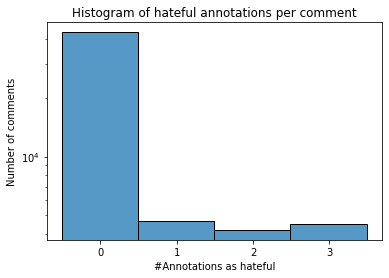

In [63]:
import seaborn as sns
import matplotlib.pyplot as plt


sns.histplot(x=[len(c['HATE']) for c in comments], bins=[0, 0.99, 1.99, 2.99, 3.99])

plt.xticks([0.5, 1.5, 2.5, 3.5], [0, 1, 2, 3])
plt.xlabel("#Annotations as hateful")
plt.ylabel("Number of comments")
plt.semilogy()
plt.title("Histogram of hateful annotations per comment")

In [9]:
possibly_hateful = len([c for c in comments if len(c['HATE']) > 0])
hateful = len([c for c in comments if len(c['HATE']) >= 2])

full_agreement = len([c for c in comments if len(c['HATE']) == 3])

print(f"Comentarios totales                             : {len(comments)}")
print(f"Comentarios con >= 1 etiqueta de discriminación : {possibly_hateful}")
print(f"Comentarios con >= 2 etiqueta de discriminación : {hateful}")
print(f"Comentarios con >= 3 etiqueta de discriminación : {full_agreement}")
print(f"Ratio de comentarios odiosos (>= 2) sobre totales = {hateful / len(comments):.3f}")

Comentarios totales                             : 56869
Comentarios con >= 1 etiqueta de discriminación : 13366
Comentarios con >= 2 etiqueta de discriminación : 8715
Comentarios con >= 3 etiqueta de discriminación : 4514
Ratio de comentarios odiosos (>= 2) sobre totales = 0.153


## Agreement

In [10]:
from api.metrics import AgreementCalculator

calculator = AgreementCalculator(articles=dataset_articles)

  0%|          | 0/4769 [00:10<?, ?it/s]

In [11]:
calculator.users = None

In [12]:
categories = [
    'HATE',
    'CALLS',
    'MUJER',
    'LGBTI',
    'RACISMO',
    'POBREZA',
    'DISCAPACIDAD',
    'POLITICA',
    'ASPECTO',
    'CRIMINAL',
]

agreement_df = pd.DataFrame([{
    "Category": category,
    "Agreement": calculator.get_agreement(on=category)[0],
} for category in categories])
agreement_df.set_index("Category")

,Agreement
Category,
HATE,0.579610
CALLS,0.641360
MUJER,0.783391
LGBTI,0.920701
RACISMO,0.929094
POBREZA,0.706778
DISCAPACIDAD,0.849856
POLITICA,0.808519
ASPECTO,0.871752


Obs: acá los agreements por categorías se ven sólo en aquellos comentarios que son marcados como odiosos, y sólo entre aquellos

En términos de cómo calculamos el alpha de Krippendorff: supongamos que estamos calculando el agreement de MUJER. Si anotador A1 y A2 marcaron como odioso C1, y ambos marcaron mujer => en ambos va 1. Anotador A3 no marcó como odioso ese comentario => va nan. En C2, A1 no marcó como odioso y A2 y A3 marcaron como odioso contra MUJER. En C3, A3 no marcó odioso, y A1 sí pero sin marcar MUJER y A2 marcó odioso y MUJER.

La matriz quedaría así:

|   |C1   |C2    | C3   |
|---|-----|------|------|
|A1 | 1   | nan  | 0    |
|A2 | 1   | 1    | 1    |
|A3 | nan | 1    | nan  |

## Asignación



In [16]:

raw_articles = articles
raw_comments = comments

In [23]:
hate_categories = [
    'WOMEN',
    'LGBTI',
    'RACISM',
    'CLASS',
    'DISABLED',
    'POLITICS',
    'APPEARANCE',
    'CRIMINAL',
]


def process_comment(raw_comment):
    """
    Process raw comment
    """
    ret = {
        "id": raw_comment["id"],
        "text": raw_comment["text"],
        "HATEFUL": int(len(raw_comment['HATE']) >= 2)
    }
    for cat in hate_categories + ["CALLS"]:
        ret[cat] = 0

    if ret["HATEFUL"]:
        ret["CALLS"] = int(len(raw_comment['CALLS']) >= 2)

        for category in hate_categories:
            ret[category] = int(len(raw_comment[category]) > 0)

    return ret

articles = {art['tweet_id']:art for art in raw_articles}

for art in articles.values():
    art["comments"] = []

counts = []


for comment in tqdm(raw_comments):
    tweet_id = comment["article_id"]
    article = articles[tweet_id]
    article["comments"].append(
        process_comment(comment)
    )


  0%|          | 0/56869 [00:00<?, ?it/s]

In [32]:
comments = [comment for _, article in articles.items() for comment in article["comments"]]

df_comments = pd.DataFrame(comments)

df_comments.set_index("id", inplace=True)
df_comments[labelled_columns] = df_comments[labelled_columns].astype(bool)

hateful_comments = df_comments[df_comments["HATEFUL"]]

Text(0, 0.5, 'Number of comments')

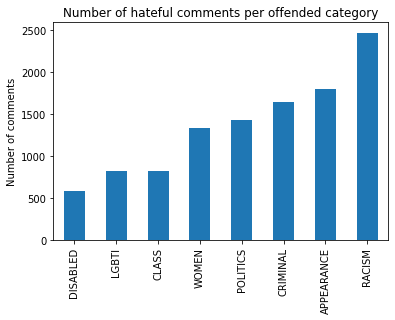

In [44]:
categories = [x for x in labelled_columns if x not in ["HATEFUL", "CALLS"]]
hateful_comments[categories].sum().sort_values().plot(kind="bar")

plt.title("Number of hateful comments per offended category")
plt.ylabel("Number of comments")

Text(0, 0.5, 'Number of comments')

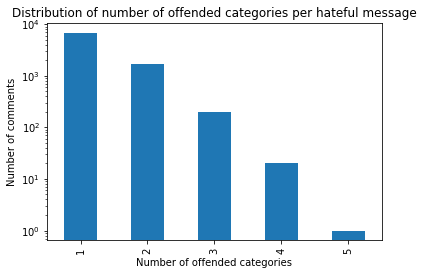

In [51]:
categories = [x for x in labelled_columns if x not in ["HATEFUL", "CALLS"]]
hateful_comments[categories].sum(axis=1).value_counts().plot(kind="bar")


plt.semilogy()
plt.title("Distribution of number of offended categories per hateful message")

plt.xlabel("Number of offended categories")
plt.ylabel("Number of comments")

Text(0.5, 1.0, 'Correlation between offended categories')

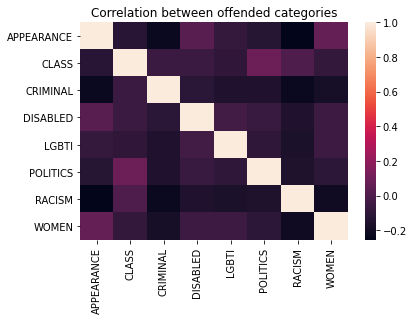

In [58]:
sns.heatmap(hateful_comments[categories].corr())

plt.title("Correlation between offended categories")